In [111]:
import gtdynamics as gtd
from gtdynamics import ContactGoal, PointOnLink, Slice, Interval
from gtsam import Pose3, Point3
import plotly.express as px
import pybullet as p
import gtsam

In [112]:
robot = gtd.CreateRobotFromFile(gtd.URDF_PATH + "/humanoid/nao.urdf");

In [113]:
link_names = [(link.id(), link.name()) for link in robot.links()]
link_names.sort()
print(link_names)

[(0, 'base_link'), (1, 'Neck'), (2, 'Head'), (3, 'LPelvis'), (4, 'LHip'), (5, 'LThigh'), (6, 'LTibia'), (7, 'LAnklePitch'), (8, 'l_ankle'), (9, 'LShoulder'), (10, 'LBicep'), (11, 'LElbow'), (12, 'LForeArm'), (13, 'l_wrist'), (14, 'LFinger11_link'), (15, 'LFinger12_link'), (16, 'LFinger13_link'), (17, 'LFinger21_link'), (18, 'LFinger22_link'), (19, 'LFinger23_link'), (20, 'l_gripper'), (21, 'LThumb1_link'), (22, 'LThumb2_link'), (23, 'RPelvis'), (24, 'RHip'), (25, 'RThigh'), (26, 'RTibia'), (27, 'RAnklePitch'), (28, 'r_ankle'), (29, 'RShoulder'), (30, 'RBicep'), (31, 'RElbow'), (32, 'RForeArm'), (33, 'r_wrist'), (34, 'RFinger11_link'), (35, 'RFinger12_link'), (36, 'RFinger13_link'), (37, 'RFinger21_link'), (38, 'RFinger22_link'), (39, 'RFinger23_link'), (40, 'r_gripper'), (41, 'RThumb1_link'), (42, 'RThumb2_link')]


In [114]:
# Figure out which feet are front, back:
for name in ["r_wrist","l_wrist","l_ankle","r_ankle"]:
    print(name, robot.link(name).wTcom().translation())
print(dir(robot.link("r_gripper")))
print(robot.link("r_gripper").lTcom())

r_wrist [ 0.19529 -0.11212  0.10308]
l_wrist [0.19529 0.11212 0.10308]
l_ankle [ 0.02541975  0.05330005 -0.32029059]
r_ankle [ 0.02541975 -0.05330005 -0.32029059]
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'addJoint', 'centerOfMass', 'fix', 'getFixedPose', 'id', 'inertia', 'inertiaMatrix', 'isFixed', 'joints', 'lTcom', 'mass', 'name', 'numJoints', 'shared', 'unfix', 'wTcom', 'wTl']
R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 0 0 0



In [136]:
LH = PointOnLink(robot.link("l_gripper"), robot.link("l_wrist").lTcom().translation())
LF = PointOnLink(robot.link("l_ankle"), robot.link("l_ankle").lTcom().translation())
RH = PointOnLink(robot.link("r_gripper"), robot.link("r_wrist").lTcom().translation())
RF = PointOnLink(robot.link("r_ankle"), robot.link("r_ankle").lTcom().translation())

# Test trivial inverse kinematics 
contact_goals = [
    ContactGoal(LH, robot.link("l_gripper").wTcom().translation()),
    ContactGoal(LF, robot.link("l_ankle").wTcom().translation()),
    ContactGoal(RH, robot.link("r_gripper").wTcom().translation()),
    ContactGoal(RF, robot.link("r_ankle").wTcom().translation()),
    ]
print(contact_goals)

[{{l_gripper, [ 0.03434 -0.00088  0.00308]}, [ 0.2187   0.113 0.08769]}, {{l_ankle, [ 0.0254198 0.00330005 -0.0323906]}, [0.0254198 0.0533001 -0.320291]}, {{r_gripper, [0.03434 0.00088 0.00308]}, [ 0.2187  -0.113 0.08787]}, {{r_ankle, [  0.0254198 -0.00330005  -0.0323906]}, [ 0.0254198 -0.0533001  -0.320291]}]


In [137]:
kinematics = gtd.Kinematics(robot)
result = kinematics.inverseSlice(Slice(4), contact_goals)

In [138]:
for goal in contact_goals:
    print(goal.link().name(), goal.satisfied(result,k=4,tol=1e-3))

l_gripper True
l_ankle True
r_gripper True
r_ankle True


In [127]:
robot.link("l_ankle").wTcom().translation()

array([ 0.02541975,  0.05330005, -0.32029059])

In [120]:
import numpy as np
points = np.asarray([robot.link("l_gripper").wTcom().translation(), 
                     robot.link("l_ankle").wTcom().translation(), 
                     robot.link("r_gripper").wTcom().translation(), 
                     robot.link("r_ankle").wTcom().translation()])

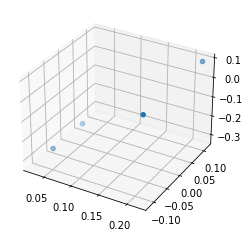

In [121]:
from mpl_toolkits import mplot3d


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt



fig = plt.figure()
ax = plt.axes(projection='3d')


ax.scatter3D(points[:, 0], points[:, 1], points[:, 2]);

In [123]:
robot.link("l_ankle").wTcom().translation()

array([ 0.02541975,  0.05330005, -0.32029059])

In [139]:
import unittest

class TestRobot(unittest.TestCase):
    
    def testInverseKinematicsHands(self):
        robot = gtd.CreateRobotFromFile(gtd.URDF_PATH + "/humanoid/nao.urdf")
        contact_goals = [
            ContactGoal(LH, [.01, .113, .26]),
            ContactGoal(LF, robot.link("l_ankle").wTcom().translation()),
            ContactGoal(RH, [.01, -.113, .26]),
            ContactGoal(RF, robot.link("r_ankle").wTcom().translation()),
        ]
        kinematics = gtd.Kinematics(robot)
        result = kinematics.inverseSlice(Slice(4), contact_goals)
        for goal in contact_goals:
            self.assertTrue(goal.satisfied(result,k=4,tol=1e-3))
            
    def testInverseKinematicsAll(self):
        robot = gtd.CreateRobotFromFile(gtd.URDF_PATH + "/humanoid/nao.urdf")
        contact_goals = [
            ContactGoal(LH, [.01, .113, .26]),
            ContactGoal(LF, [0.025, 0.05, -0.3]),
            ContactGoal(RH, [.01, -.113, .26]),
            ContactGoal(RF, [0.025, -0.05, -0.3]),
        ]
        kinematics = gtd.Kinematics(robot)
        result = kinematics.inverseSlice(Slice(4), contact_goals)
        for goal in contact_goals:
            self.assertTrue(goal.satisfied(result,k=4,tol=1e-3))
            
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.775s

OK


In [11]:
_link_name_to_index = {p.getBodyInfo(pybullet_robot)[0].decode('UTF-8'):-1,}
        
for _id in range(p.getNumJoints(pybullet_robot)):
    _name = p.getJointInfo(pybullet_robot, _id)[12].decode('UTF-8')
    _link_name_to_index[_name] = _id

In [12]:
_link_name_to_index

{'base_link': -1,
 'torso': 0,
 'Neck': 1,
 'Head': 2,
 'gaze': 3,
 'HeadTouchFront_frame': 4,
 'CameraBottom_frame': 5,
 'CameraBottom_optical_frame': 6,
 'CameraTop_frame': 7,
 'CameraTop_optical_frame': 8,
 'LInfraRed_frame': 9,
 'HeadTouchRear_frame': 10,
 'HeadTouchMiddle_frame': 11,
 'RInfraRed_frame': 12,
 'LPelvis': 13,
 'LHip': 14,
 'LThigh': 15,
 'LTibia': 16,
 'LAnklePitch': 17,
 'l_ankle': 18,
 'l_sole': 19,
 'LFootBumperRight_frame': 20,
 'LFsrFR_frame': 21,
 'LFsrRR_frame': 22,
 'LFsrFL_frame': 23,
 'LFsrRL_frame': 24,
 'LFootBumperLeft_frame': 25,
 'RPelvis': 26,
 'RHip': 27,
 'RThigh': 28,
 'RTibia': 29,
 'RAnklePitch': 30,
 'r_ankle': 31,
 'r_sole': 32,
 'RFsrRL_frame': 33,
 'RFsrRR_frame': 34,
 'RFootBumperRight_frame': 35,
 'RFsrFR_frame': 36,
 'RFootBumperLeft_frame': 37,
 'RFsrFL_frame': 38,
 'LShoulder': 39,
 'LBicep': 40,
 'LElbow': 41,
 'LForeArm': 42,
 'l_wrist': 43,
 'l_gripper': 44,
 'LHandTouchLeft_frame': 45,
 'LHandTouchBack_frame': 46,
 'LHandTouchRight_f

In [15]:
robot.forwardKinematics(vals, 42)

RuntimeError: forwardKinematics: no prior link given and cannot find a fixed link.

In [ ]:
vals = gtd.Values()

In [ ]:
vals.insert(0, gtsam.Rot2(-0.5380427144113512))
vals.insert(1, gtsam.Rot2(-0.10427144113512))

In [ ]:
vals

In [2]:
gtd.__dict__.keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', 'gtsam', 'gtdynamics', 'URDF_PATH', 'SDF_PATH', 'GTDKeyFormatter', 'PoseFactor', 'ForwardKinematicsFactor', 'TwistFactor', 'TwistAccelFactor', 'TorqueFactor', 'MinTorqueFactor', 'WrenchFactor', 'WrenchEquivalenceFactor', 'WrenchPlanarFactor', 'EulerPoseColloFactor', 'TrapezoidalPoseColloFactor', 'EulerTwistColloFactor', 'TrapezoidalTwistColloFactor', 'Link', 'JointParams', 'Joint', 'JointTyped', 'ScrewJointBase', 'RevoluteJoint', 'PrismaticJoint', 'ScrewJoint', 'Robot', 'OptimizerSetting', 'CollocationScheme', 'ContactPoint', 'DynamicsGraph', 'add_link_objectives', 'add_joint_objectives', 'DynamicsSymbol', 'internal', 'Simulator', 'Phase', 'WalkCycle', 'Trajectory', 'CreateRobotFromFile', 'ZeroValues', 'ZeroValuesTrajectory', 'ContactWrenchKey', 'PhaseKey', 'TimeKey', 'InsertJointAngleDouble', 'JointAngle', 'JointAngleDouble', 'InsertJointVelDouble', 'JointVe